# ECE 4950 Assignment 5 

# Yanling Wu  (yw996)

## Coding (Support Vector Machines): Digit classification using SVM

We consider hand written digit recognition, MNIST. Please visit http://yann.lecun.com/exdb/mnist/ for more information about the original MNIST dataset.

In this competition, you will be given images of hand written digits. Each image is grayscale, and 28 by 28 pixels. Your goal is to design a classifier for this problem (output digits from 0 to 9).

Make sure you have installed the package scikit-image:

``
    pip3 install scikit-image
``

or 


``
    conda install scikit-image
``

You can use the following script to load data.

In [1]:
%matplotlib inline
from scipy.io import loadmat
import numpy as np
data_path = "./mnist.mat"
data_raw = loadmat(data_path)
images = data_raw['data'].T
label = data_raw['label'][0]

Data will be an array of 70000 784-length numpy arrays. 50000 of them will be the training data and 20000 of them will be the testing data. The corresponding labels of training data are also provided. 

Each vector represents an image of size $28 \times 28$. The original black and white images were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field. 

You can reshape each vector to be an $28 \times 28$ matrix and plot the image using the following script. Typical images will look like the following:

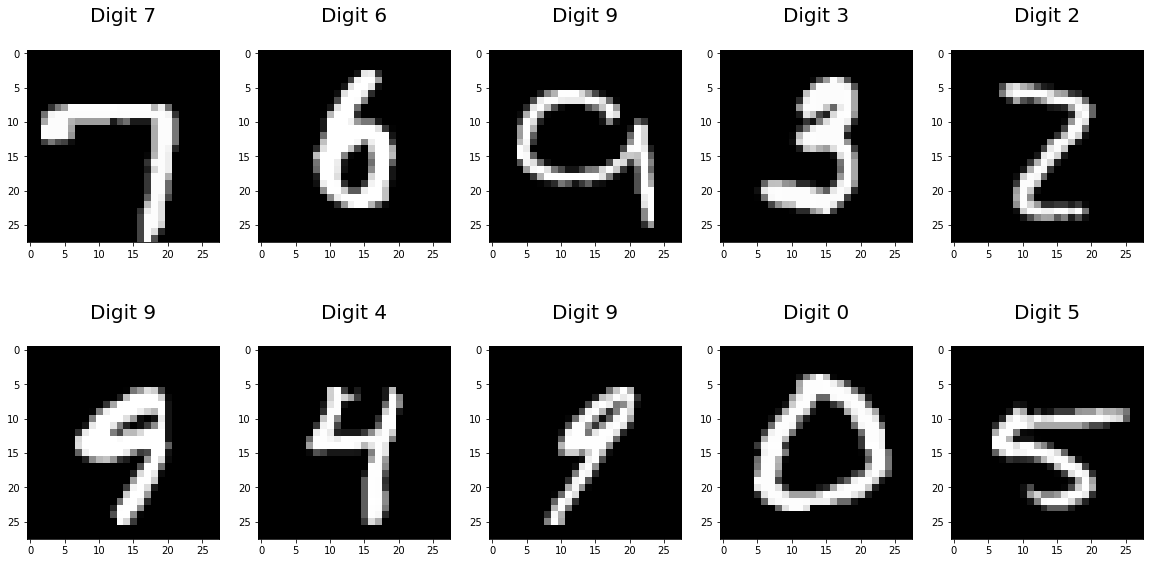

In [2]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(20,10))
for i in range(10,20):
    plt.subplot(2, 5, i-9)
    t = random.randint(0,70000)
    plt.imshow(np.reshape(images[t,:], (28,28)), cmap = plt.cm.gray)
    plt.title('Digit %i\n' %label[t], fontsize = 20)

### Sampling, Normalization and Data splitting

To make training faster, we only take 10% of the data randomly. Then we further reduce the dimension of the data by taking the average of each  Then we split the data into training and testing set and normalize them by max norm.

In [3]:
from sklearn.model_selection import train_test_split
X_new, X_unused, Y_new, Y_unused = train_test_split(images, label, test_size = 0.9, random_state = 1000)
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_new, Y_new, test_size = 0.3, random_state = 1000) # split the dataset into training and testing sets
X_trn = X_trn/256
X_tst = X_tst/256

### Image Rescaling
To make the training even faster. The next code block rescale all the images by reducing the height and width of the image both by half. We make each $2\time 2$ block in the orginal image into a single pixel in the new image. The resulting value of the pixels in the new image will be the average of the original four pixels.

Then we get new images with $14 \times 14$ in size and stores in the rows of X_trn_new and X_tst_new.

In [7]:
from skimage.transform import rescale, resize, downscale_local_mean
m, n = X_trn.shape
n_new = n//4
X_trn_new = np.zeros((m,n_new))
for i in range(m):
    image = np.reshape(X_trn[i,:], (28,28))
    image_rescaled = rescale(image, 1.0 / 2.0, anti_aliasing=False)
    X_trn_new[i,:] = np.reshape(image_rescaled, n_new)

m2 = X_tst.shape[0]
X_tst_new = np.zeros((m2,n_new))
for i in range(m2):
    image = np.reshape(X_tst[i,:], (28,28))
    image_rescaled = rescale(image, 1.0 / 2.0, anti_aliasing=False)
    X_tst_new[i,:] = np.reshape(image_rescaled, n_new)
    
print('The new training set has size: '+ str(X_trn_new.shape))
print('The new testing set has size: '+ str(X_tst_new.shape))

D:\Softwares\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
D:\Softwares\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


The new training set has size: (4900, 196)
The new testing set has size: (2100, 196)


## 1. Linear SVM
Run a linear SVM for the penalty parameter $$C \in \{2^i: i = 0, 1, ..., 19\}$$, and plot the training and testing accuracy as a function of $log C$ (semi-log plot).

Explain how the accuracy changes with repect to penalty parameter $C$ (describe the underfitting and overfitting phenomenon). 

What is the maximum testing accruracy achieved among all penalty parameters for linear SVM?

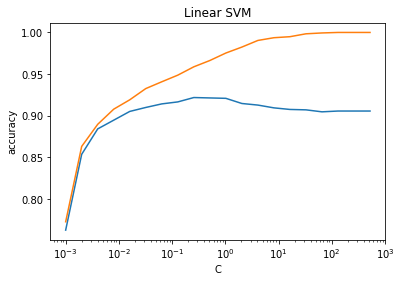

The maximum testing accuracy achieved with Linear SVM is: 0.9219047619047619


In [34]:
from sklearn.svm import SVC
n = np.array(range(20))
C = 0.001*2**n
accuracy_tst = []
accuracy_trn = []
#========Your Code Here============

for i in n:
    clf = SVC(C=C[i],kernel='linear',gamma='auto').fit(X_trn_new, Y_trn)
    accuracy_tst.append(clf.score(X_tst_new, Y_tst))
    accuracy_trn.append(clf.score(X_trn_new, Y_trn))
max_acc = np.max(accuracy_tst)
#=============================
plt.semilogx(C, accuracy_tst)
plt.semilogx(C, accuracy_trn)
plt.title("Linear SVM")
plt.xlabel('C')
plt.ylabel('accuracy')
plt.show()
print('The maximum testing accuracy achieved with Linear SVM is: ' + str(max_acc))

### Explaination: 

For soft-margin SVM, we are minimizing the following quantity:

$$||w||_2^2+C\sum_i max\{1−y_i(w⋅x_i−t),0\}$$

$||w||_2^2$ can be seen as the regularization term and $\sum_i max\{1−y_i(w⋅x_i−t),0\}$ can be seen as the error we make on the training set. So increasing C means we are putting more weight on minimizing the training error. 

Thus, when C is too small, the weight on minimizing the training error will be too small, and the model is underfitting. That is why when increasing C at first, the accuracy of the training dataset and the test dataset both increase. 

But when increasing C continuously, the accuracy of the training dataset increases significantly; the accuracy of the testing dataset stays stable and then decreases a littlt bit. Because the model is overfitting. 

The maximum testing accuracy achieved with Linear SVM is: 0.9219

## 2. Polynomial SVM
Run an SVM with polynomial kernal of degree $2, 3, 4$ with the penalty parameter $$C \in \{2^i: i = 0, 1, ..., 19\}$$, and plot the training and testing accuracy as a function of $log C$ (semi-log plot).

Explain how the accuracy changes with repect to penalty parameter $C$ (describe the underfitting and overfitting phenomenon). 

What is the maximum testing accruracy achieved among all penalty parameters for SVM with polynomial kernal of each degree? Compare it with linear SVM and explain.

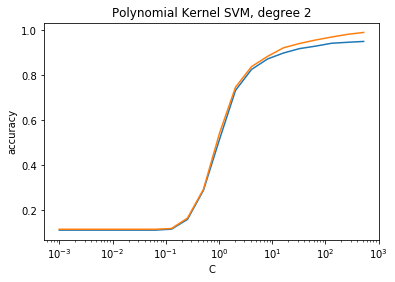

The maximum testing accuracy achieved with Polynomial Kernel SVM of degree 2 is: 0.950952380952381


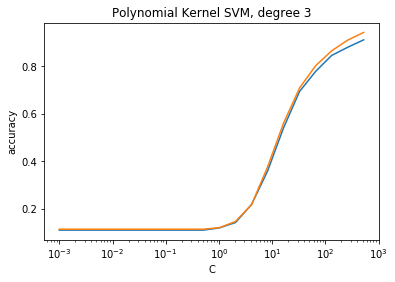

The maximum testing accuracy achieved with Polynomial Kernel SVM of degree 3 is: 0.910952380952381


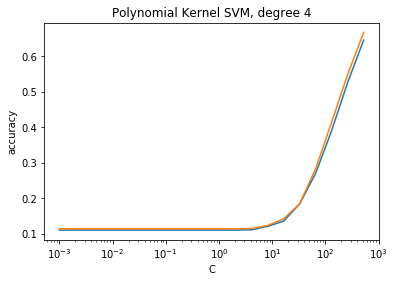

The maximum testing accuracy achieved with Polynomial Kernel SVM of degree 4 is: 0.6452380952380953


In [35]:
from sklearn.svm import SVC
D = [2, 3, 4]
n = np.array(range(20))
C = 0.001*2**n
max_acc = np.zeros(3)
for i in range(3):
    accuracy_tst = []
    accuracy_trn = []
    d = D[i]
    #========Your Code Here============
    for j in n:
        clf = SVC(C=C[j],kernel='poly',degree=d, gamma='auto').fit(X_trn_new, Y_trn)
        y_tst_pre = clf.predict(X_tst_new)
        #print(y_tst_pre.shape, Y_tst.shape)
        accuracy_tst.append(accuracy_score(y_tst_pre, Y_tst))
        y_trn_pre = clf.predict(X_trn_new)
        accuracy_trn.append(accuracy_score(y_trn_pre, Y_trn))
    max_acc[i] = np.max(accuracy_tst)
    #=============================
    plt.semilogx(C, accuracy_tst)
    plt.semilogx(C, accuracy_trn)
    plt.title("Polynomial Kernel SVM, degree %i" %d)
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.show()
    print('The maximum testing accuracy achieved with Polynomial Kernel SVM of degree ' + str(d) + ' is: ' + str(max_acc[i]))

### Explaination: 

In fact, the polynomial model could be seen as the higher dimension linear model. So different order of the polynomial model could be seen as the linear model with different dimensions. So the reason why the accuracy changes with repect to penalty parameter $C$ is similar to the first problem. C could change the weight on minimizing the training error. 

At first, C is very small, the accuracy of these three orders of polynomial model are all lower than 0.2, which means the models are underfitting. As the increasing of the C, the models are becoming more comlex and more suitable the dataset, so the accuracy of these three orders polynomial model also increase. And increasing the C continously, we could see the accuracy of the training dataset could be more than the that of the testing dataset, which means the models begin to overfit. 

The maximum testing accuracy of Polynomial Kernel SVM of degree 2 is 0.95095 which is the biggest one in these three degrees of polynomial kernel. When increasing the degree of the polynomial kernel, the accuracy did not increase. And the overfitting phnomenon appears early. I think this means the higher degree polynominal kernel does not fit this dataset and thus is easy to overfitting because the models are too complex. 

## 3. SVM with Gaussian Kernal.
Run an SVM with Gaussian kernal with the penalty parameter $$C \in \{2^i: i = 0, 1, ..., 19\}$$, and plot the training and testing accuracy as a function of $log C$ (semi-log plot).

Explain how the accuracy changes with repect to penalty parameter $C$ (describe the underfitting and overfitting phenomenon). 

What is the maximum testing accruracy achieved among all penalty parameters for SVM with Gaussian kernal of each degree? Compare it with linear SVM and polynomial SVM and explain.

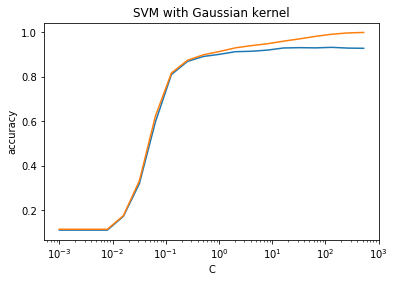

The maximum testing accuracy achieved with SVM with Gaussian kernel is: 0.9323809523809524


In [36]:
from sklearn.svm import SVC
accuracy_tst = []
accuracy_trn = []
n = np.array(range(20))
C = 0.001*2**n
#========Your Code Here============

for i in n:
    clf = SVC(C=C[i],kernel='rbf',gamma='auto').fit(X_trn_new, Y_trn)
    accuracy_tst.append(clf.score(X_tst_new, Y_tst))
    accuracy_trn.append(clf.score(X_trn_new, Y_trn))
max_acc = np.max(accuracy_tst)

#=============================
plt.semilogx(C, accuracy_tst)
plt.semilogx(C, accuracy_trn)
plt.title("SVM with Gaussian kernel")
plt.xlabel('C')
plt.ylabel('accuracy')
plt.show()
print('The maximum testing accuracy achieved with SVM with Gaussian kernel is: ' + str(max_acc))

### Explaination: 

Simiar to the first two questions, C could change the weight of the training error. So when the C is small, the weight of the training error is small so that the model is underfitting and the accuracy of the testing and training erro both are low. As the increasing of C, the model becomes more suitable for the dataset, the accuracy of the testing and training dataset increase too. But when C becomes too big, the model becomes overfitting. 

The maximum testing accuracy achieved with SVM with Gaussian kernel is: 0.9323. 

The maximum testing accuracy of Polynomial Kernel SVM is 0.95095 when degree is 2. 

The maximum testing accuracy achieved with Linear SVM is: 0.9219. 

From these three maximum testing accuracies, we could know the polynominal kernel SVM has the highest accuracy but if we want to use polynominal kernel, we must choose the suitable degree of polynomial kernel or we might get worse model. As for linear SVM, the accuracy is similar to the Gaussian kernel. But after googling some papers, I know that:

1. Use linear kernel when the numbre of features is larger than the number of training set; 

2. Use Gaussian kenel when the number of training set is larger than the number of the features;